In [220]:
import tensorflow as tf
from forward_kinematics import forward_kinematics
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [221]:
def cos(t):
    return np.cos(np.deg2rad(t))

# Create data

In [236]:
# Generate 220000 samples
x_samples=[]
y_samples=[]
l1=104.
#for i in range(220000):
for i in range(220000):
    T1=np.random.randint(0,91)
    T2=np.random.randint(0,91)
    T3=np.random.randint(0,91)
    T4=np.random.randint(0,91)        
    fk=forward_kinematics(T1,T2,T3,T4)[:3,3]
    dx=fk[0]
    dy=fk[1]
    dz=fk[2]
    r = np.sqrt(dx**2+dy**2)
    if(T2>90):
        print(T2)
    x_samples.append([r,dz])
    y_samples.append([T2])
    
x_samples=np.array(x_samples).reshape(-1,1,2)
y_samples=np.array(y_samples,dtype=np.float32)
#y_samples=tf.one_hot(y_samples,depth=90)

In [242]:
x_samples[:,0,1]

array([  -7.,   -5.,  194., ...,  -56., -109.,   26.])

C:\Users\salih\AppData\Local\Temp\ipykernel_6924\2774429093.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x_samples[:,0,0][:1000]/x_samples[:,0,1][:1000],y_samples[:1000])


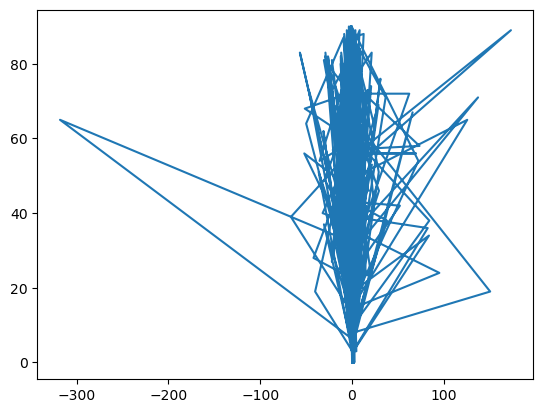

In [246]:
import matplotlib.pyplot as plt
plt.plot(x_samples[:,0,0][:1000]/x_samples[:,0,1][:1000],y_samples[:1000])

C:\Users\salih\AppData\Local\Temp\ipykernel_6924\980096072.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) # Method 1


Text(0.5, 0, 'Z Label')

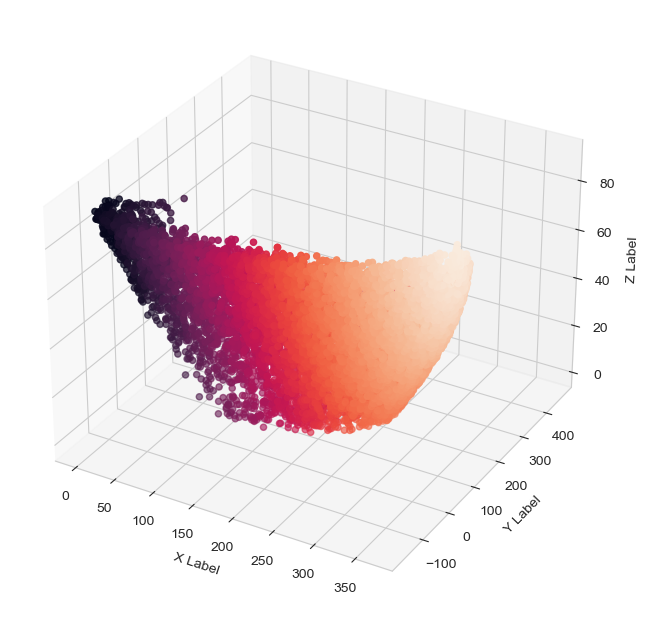

In [259]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

z = y_samples[:10000]
x = x_samples[:,0,0][:10000]
y = x_samples[:,0,1][:10000]


ax.scatter(x, y, z, c=x, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

## Data normalization

In [6]:
# Step 1: Determine the Range
#min_dx, max_dx = min(dx), max(dx)
min_r, max_r = min(dr), max(dr)
#min_dy, max_dy = min(dy), max(dy)
min_dz, max_dz = min(dz), max(dz)

# Step 2: Normalize Each Variable
#normalized_dx = [(x - min_dx) / (max_dx - min_dx) for x in dx]
#normalized_dy = [(y - min_dy) / (max_dy - min_dy) for y in dy]
normalized_dz = [(z - min_dz) / (max_dz - min_dz) for z in dz]
normalized_r = [(r - min_r) / (max_r - min_r) for r in dr]
# Normilize Y samples
#normalized_y =np.array([t2/90 for t2 in y_samples])
normalized_y =np.array([t2 for t2 in y_samples])

In [7]:
#normalized_dx[0],normalized_dy[0],normalized_dz[0]
normalized_r[0],normalized_dz[0]

(0.7085465607623419, 0.20253164556962025)

In [8]:
#normalized_x=np.transpose(np.array([normalized_dx,normalized_dy,normalized_dz]))
normalized_x=np.transpose(np.array([normalized_r,normalized_dz]))
normalized_x

array([[0.70854656, 0.20253165],
       [0.83569514, 0.41772152],
       [0.55557914, 0.78797468],
       ...,
       [0.61137023, 0.43987342],
       [0.55912371, 0.07594937],
       [0.84221915, 0.34810127]])

In [9]:
#normalized_y=np.transpose(np.array([normalized_dT2,normalized_dT3,normalized_dT4]))
#normalized_y

# Split data

In [160]:
X_train = x_samples[:200000]
y_train = y_samples[:200000]

In [161]:
X_val = x_samples[200000:]
y_val = y_samples[200000:]

In [162]:
print(len(x_samples))

220000


In [206]:
train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32)

# Create model

In [207]:
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
num_labels = 90

norm_layer.adapt(data=train.map(map_func=lambda spec, label: spec))

In [216]:
inputs = layers.Input(shape=(1,2))
x=norm_layer(inputs)
x=layers.Dense(32, activation='tanh')(x)
x=layers.Dense(64,activation='tanh')(x)
x=layers.Dense(128, activation='tanh')(x)
x=layers.Dense(128, activation='tanh')(x)
x=layers.Dense(256, activation='tanh')(x)

#x=layers.Resizing(90,1)(x)
out=layers.Dense(90,activation="softmax")(x)

model_1=tf.keras.Model(inputs,out)

In [217]:
# Compile model
loss = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, restore_best_weights=True)
model_1.compile(loss=loss, optimizer=optimizer, metrics=tf.metrics.Accuracy())

In [218]:
model_1.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 1, 2)]            0         
                                                                 
 normalization_8 (Normalizat  (None, 1, 2)             5         
 ion)                                                            
                                                                 
 dense_120 (Dense)           (None, 1, 32)             96        
                                                                 
 dense_121 (Dense)           (None, 1, 64)             2112      
                                                                 
 dense_122 (Dense)           (None, 1, 128)            8320      
                                                                 
 dense_123 (Dense)           (None, 1, 128)            16512     
                                                          

In [ ]:
# Train model
model_1.fit(train, 
            epochs=150,
            validation_data=val, 
            callbacks=[early_stop])

Epoch 1/150
6250/6250 [==============================] - 7s 1ms/step - loss: 3.4610 - accuracy: 0.0000e+00 - val_loss: 3.3944 - val_accuracy: 0.0000e+00
Epoch 2/150
6250/6250 [==============================] - 6s 994us/step - loss: 3.3065 - accuracy: 0.0000e+00 - val_loss: 3.3551 - val_accuracy: 0.0000e+00
Epoch 3/150
6250/6250 [==============================] - 6s 991us/step - loss: 3.2553 - accuracy: 0.0000e+00 - val_loss: 3.3052 - val_accuracy: 0.0000e+00
Epoch 4/150
6250/6250 [==============================] - 6s 1ms/step - loss: 3.2250 - accuracy: 0.0000e+00 - val_loss: 3.2808 - val_accuracy: 0.0000e+00
Epoch 5/150
6250/6250 [==============================] - 6s 1ms/step - loss: 3.2057 - accuracy: 0.0000e+00 - val_loss: 3.2540 - val_accuracy: 0.0000e+00
Epoch 6/150
4596/6250 [=====================>........] - ETA: 1s - loss: 3.1944 - accuracy: 0.0000e+00

In [ ]:
numval=2
X_train[numval],np.argmax(y_train[numval])

In [ ]:
pred=model_1.predict(X_train[numval])
np.argmax(pred)

In [ ]:
y_train

# Predict using model

In [171]:
T1=np.random.randint(0,91)
T2=np.random.randint(0,91)
T3=np.random.randint(0,91)
T4=np.random.randint(0,91)    
print(T1,T2,T3,T4)
fk=forward_kinematics(T1,T2,T3,T4)[:3,3]
fk

20 40 70 62


array([164., -60., -29.])

In [23]:
#predict_dx=(fk[0] - min_dx) / (max_dx - min_dx) 
#predict_dx

In [24]:
predict_r=(np.sqrt(fk[0]**2+fk[1]**2) - min_r) / (max_r - min_r) 
predict_r

0.98476119017721

In [25]:
#predict_dy=(fk[1] - min_dy) / (max_dy - min_dy) 
#predict_dy

In [26]:
predict_dz=(fk[2] - min_dz) / (max_dz - min_dz) 
predict_dz

0.370253164556962

In [37]:
output=model_1.predict([[predict_r,predict_dz]])
np.argmax(output)

1/1 [==============================] - 0s 16ms/step


86

In [28]:
T1= np.arctan(fk[1]/fk[0])
T1=np.degrees(-T1)
T1=np.round(T1)
T1

63.0

In [29]:
forward_kinematics(T1,output[0],output[1],output[2])[:3,3]

array([  0.,  -0., 463.])

In [30]:
fk

array([ 165., -323.,   65.])

In [31]:
out=np.round(output*90)[0]
out

0.0

In [32]:
def cos(t):
    return np.cos(np.deg2rad(t))
def sin(t):
    return np.sin(np.deg2rad(t))
def finder(fk, i):
    dx,dy,dz=fk
    eT2=i
    l1=104.
    l2=89.
    l3=175.
    r = np.sqrt(dx**2+dy**2)
    r1 = cos(eT2)*l1
    r2 = r-r1
    t = sin(eT2)*l1
    t1=t-(dz-95)
    if(t1!=0):        
        alpha1=np.arctan(r2/t1)
        alpha1=np.degrees(alpha1)
    else:
        alpha1=0
    b=np.sqrt(t1**2+r2**2)
    operation1=(l2**2+b**2-l3**2)/(2*l2*b)
    operation2=(l2**2+l3**2-b**2)/(2*l2*l3)
    if(int(operation1*100)>100 or int(operation1*100)<-100):
        raise Exception() 
    if(int(operation1*100)==100 or int(operation1*100)==-100):
        operation1=np.round(operation1)
        
    if(int(operation2*100)>100 or int(operation2*100)<-100):
        raise Exception() 
    if(int(operation2*100)==100 or int(operation2*100)==-100):
        operation2=np.round(operation2)

    alpha2=np.arccos(operation1)
    alpha2=np.degrees(alpha2)
    if(t1>0):
        T3=180-(alpha1+alpha2+i)
        T3=np.round(T3)
    else:
        T3=alpha1+alpha2+i
        T3=abs(np.round(T3))
    T4=np.arccos(operation2)

    T4=np.degrees(T4)
    T4=180-T4
    T4=np.round(T4)
    T1= np.arctan(dy/dx)
    T1=np.degrees(-T1)
    T1=np.round(T1)
    #if T3>90 or T4>90:
     #   raise Exception()
    return [T1,T2,T3[0], T4[0]]

In [33]:
predicted=finder(fk,out)

IndexError: invalid index to scalar variable.

In [ ]:
predict_fk=forward_kinematics(*predicted)[:3,3]
predict_fk

In [ ]:
fk